# GENG5551 Prototype Model Training 

Run code below if using google collab for training. If not skip to next section.

run container with:
sudo docker run --gpus all -it --rm -v $(pwd):/tf/notebooks -p 8888:8888 tensorflow/tensorflow:2.12.0-gpu-jupyter

In [10]:
!pip install pandas
!pip install scikit-learn
!pip install akida==2.7.2
!pip install cnn2snn==2.7.2
%pip install akida-models==1.5.0

Note: you may need to restart the kernel to use updated packages.


In [11]:
!unzip notebooks/archive

'unzip' is not recognized as an internal or external command,
operable program or batch file.


## Dataset Preprocessing

Start here if running on anaconda virtual environment

- This section involves examining and pre-processing the data to make it suitable for use with the Akida models

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os, shutil, random

In [13]:
# combine the two parts of the dataset into one folder
def combine_folders(source_folders, target_folder):
    os.makedirs(target_folder, exist_ok=True)

    for folder in source_folders:
        file_names = os.listdir(folder)
        for file_name in file_names:
            source_file_path = os.path.join(folder, file_name)
            if os.path.isfile(source_file_path):
                target_file_path = os.path.join(target_folder, file_name)
                shutil.copy(source_file_path, target_file_path)

source_folders = ['archive/HAM10000_images_part_1', 'archive/HAM10000_images_part_2']
target_folder = 'archive/data'
combine_folders(source_folders, target_folder)

In [15]:
# Load the metadata
metadata = pd.read_csv('archive/HAM10000_metadata.csv')

In [16]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [17]:
metadata['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [18]:
# There are more rows than unique lesions, so we can assume that there are multiple images for each lesion.
unique_lesion_id = metadata['lesion_id'].unique()
print("Number of rows in metadata:", len(metadata))
print('Number of unique lesions:', len(unique_lesion_id))

Number of rows in metadata: 10015
Number of unique lesions: 7470


In [19]:
# Perform train test split
from sklearn.model_selection import train_test_split
metadata['image_path'] = metadata['image_id'].apply(lambda x: os.path.join(target_folder, f"{x}.jpg"))
train_data, test_data = train_test_split(metadata, random_state=17, stratify=metadata.dx, test_size=0.10)

print(test_data['dx'].value_counts())
print(test_data.shape)

dx
nv       671
mel      111
bkl      110
bcc       51
akiec     33
vasc      14
df        12
Name: count, dtype: int64
(1002, 8)


In [20]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,archive/data\ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,archive/data\ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,archive/data\ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,archive/data\ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,archive/data\ISIC_0031633.jpg


In [21]:
train_data = train_data.set_index("image_id")
test_data = test_data.set_index("image_id")

train_id = list(train_data.index)
test_id = list(test_data.index)

In [22]:
dirs = []

# Create train and test directory
train_dir = os.path.join('archive/data/', "train")
dirs.append(train_dir)
test_dir = os.path.join('archive/data/', "test")
dirs.append(test_dir)

# Create training subfolders for diagnoses
train_nv = os.path.join(train_dir, "nv")
dirs.append(train_nv)
train_mel = os.path.join(train_dir, "mel")
dirs.append(train_mel)
train_bkl = os.path.join(train_dir, "bkl")
dirs.append(train_bkl)
train_bcc = os.path.join(train_dir, "bcc")
dirs.append(train_bcc)
train_akiec = os.path.join(train_dir, "akiec")
dirs.append(train_akiec)
train_vasc = os.path.join(train_dir, "vasc")
dirs.append(train_vasc)
train_df = os.path.join(train_dir, "df")
dirs.append(train_df)

# Create validation subfolders for diagnoses
validation_nv = os.path.join(test_dir, "nv")
dirs.append(validation_nv)
validation_mel = os.path.join(test_dir, "mel")
dirs.append(validation_mel)
validation_bkl = os.path.join(test_dir, "bkl")
dirs.append(validation_bkl)
validation_bcc = os.path.join(test_dir, "bcc")
dirs.append(validation_bcc)
validation_akiec = os.path.join(test_dir, "akiec")
dirs.append(validation_akiec)
validation_vasc = os.path.join(test_dir, "vasc")
dirs.append(validation_vasc)
validation_df = os.path.join(test_dir, "df")
dirs.append(validation_df)

for directory in dirs:
    if not os.path.exists(directory):
        os.mkdir(directory)

In [23]:
# move images to train and test dirs
target_folder = 'archive/data'
files = os.listdir(target_folder)

for image in train_id:
    file_name = str(image + '.jpg')
    label = train_data.loc[image,'dx']

    if file_name in files:
        src = os.path.join(target_folder, file_name)
        dst = os.path.join(train_dir, label, file_name)
        shutil.copyfile(src, dst)

for image in test_id:

    file_name = image + '.jpg'
    label = test_data.loc[image,'dx']

    if file_name in files:
        src = os.path.join(target_folder, file_name)
        dst = os.path.join(test_dir, label, file_name)
        shutil.copyfile(src, dst)

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Perform data augmentation
class_names = ["df", "mel","bkl", "bcc", "akiec", "vasc"]

for d in class_names:
    source_dir = 'archive/data/'
    
    aug_dir = os.path.join(source_dir,'aug_dir') 
    if not os.path.exists(aug_dir):
        os.mkdir(aug_dir)
    
    img_dir = os.path.join(aug_dir, d)
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)

    img_class = d

    img_list = os.listdir(source_dir + 'train/' + img_class)
    
    for i in img_list: 
        src = os.path.join(source_dir + 'train/' + img_class, i)
        dst = os.path.join(img_dir,i)
        shutil.copyfile(src, dst)


    path = aug_dir
    save_path = img_dir
    
    datagen = ImageDataGenerator(
        rotation_range=90,
        featurewise_center=True,
        featurewise_std_normalization=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=[0.8,1.0],
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=(0.8,1.2),
        fill_mode='reflect')
    
    batch_size = 50
    
    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpeg',
                                            save_prefix='',
                                            target_size=(224,224),
                                              color_mode='rgb',
                                            batch_size=batch_size, shuffle=False) #important Set Shuffle=False!
    
   
    
    num_wanted = 6000
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_wanted-num_files)/batch_size))


    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
    
    img_list = sorted(img_list)
    aug_list = os.listdir(img_dir)

    for number,image in enumerate(img_list):
        for filename in aug_list:
            if f"_{number}_" in filename:
                filename_new = image[5:12] + filename
                os.rename(os.path.join(img_dir,filename), os.path.join(img_dir,filename_new))

    for augfile in os.listdir(img_dir):
        if augfile not in img_list:
           shutil.move(img_dir + '/' + augfile, source_dir + 'train/' + img_class + '/' + augfile)

    
    shutil.rmtree(aug_dir)

Found 103 images belonging to 1 classes.


c:\Users\tayjo\miniconda3\envs\akida\Lib\site-packages\keras\preprocessing\image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
c:\Users\tayjo\miniconda3\envs\akida\Lib\site-packages\keras\preprocessing\image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Found 1002 images belonging to 1 classes.
Found 989 images belonging to 1 classes.
Found 463 images belonging to 1 classes.
Found 294 images belonging to 1 classes.
Found 128 images belonging to 1 classes.


In [15]:
# scale images
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=100,
    class_mode='sparse',
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=100,
    class_mode='sparse'
)

2024-05-16 11:43:57.349093: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-16 11:43:57.451327: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 9013 images belonging to 7 classes.
Found 1002 images belonging to 7 classes.


## Model Training

In [16]:
from akida_models import fetch_file, akidanet_imagenet

IMG_SIZE = 224
# CLASSES = metadata['dx'].unique()
CLASSES = 7

# Create a base model without top layers
base_model = akidanet_imagenet(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                               classes=CLASSES,
                               alpha=0.5,
                               include_top=False,
                               pooling='avg')

# Get pretrained quantized weights and load them into the base model
pretrained_weights = fetch_file(
    origin="https://data.brainchip.com/models/AkidaV2/akidanet/akidanet_imagenet_224_alpha_0.5.h5",
    fname="akidanet_imagenet_224_alpha_0.5.h5",
    cache_subdir='models')

base_model.load_weights(pretrained_weights, by_name=True)
base_model.summary()

2024-05-16 11:44:04.002537: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-16 11:44:04.011739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-16 11:44:04.011820: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

5724224/5724224 [==============================] - 3s 1us/step
Download complete.
Model: "akidanet_0.50_224_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv_0 (Conv2D)             (None, 112, 112, 16)      432       
                                                                 
 conv_0/BN (BatchNormalizati  (None, 112, 112, 16)     64        
 on)                                                             
                                                                 
 conv_0/relu (ReLU)          (None, 112, 112, 16)      0         
                                                                 
 conv_1 (Conv2D)             (N

In [17]:
from keras import Model
from keras.layers import Activation, Dropout, Reshape
from akida_models.layer_blocks import dense_block

x = base_model.output
x = dense_block(x,
                units=512,
                name='fc1',
                add_batchnorm=True,
                relu_activation='ReLU7.5')
x = Dropout(0.5, name='dropout_1')(x)
x = dense_block(x,
                units=CLASSES,
                name='predictions',
                add_batchnorm=False,
                relu_activation=False)
x = Activation('softmax', name='act_softmax')(x)
x = Reshape((CLASSES,), name='reshape')(x)

# Build the model
model_keras = Model(base_model.input, x, name='akidanet_derma')

model_keras.summary()

Model: "akidanet_derma"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv_0 (Conv2D)             (None, 112, 112, 16)      432       
                                                                 
 conv_0/BN (BatchNormalizati  (None, 112, 112, 16)     64        
 on)                                                             
                                                                 
 conv_0/relu (ReLU)          (None, 112, 112, 16)      0         
                                                                 
 conv_1 (Conv2D)             (None, 112, 112, 32)      4608      
                                                    

Epoch 1/10


2024-05-16 11:44:53.870682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-05-16 11:44:55.664504: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-05-16 11:44:56.359736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-16 11:44:56.609915: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7e177cad3290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-16 11:44:56.609935: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-05-16 11:44:56.62353

91/91 [==============================] - ETA: 0s - loss: 1.0702 - accuracy: 0.6869

2024-05-16 11:45:24.464573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


91/91 [==============================] - 34s 295ms/step - loss: 1.0702 - accuracy: 0.6869 - val_loss: 3.4463 - val_accuracy: 0.6697
Epoch 2/10
91/91 [==============================] - 26s 285ms/step - loss: 0.8599 - accuracy: 0.7495 - val_loss: 4.2658 - val_accuracy: 0.6697
Epoch 3/10
91/91 [==============================] - 26s 285ms/step - loss: 0.8396 - accuracy: 0.7536 - val_loss: 4.1300 - val_accuracy: 0.6697
Epoch 4/10
91/91 [==============================] - 26s 292ms/step - loss: 0.8552 - accuracy: 0.7451 - val_loss: 3.8672 - val_accuracy: 0.6697
Epoch 5/10
91/91 [==============================] - 26s 284ms/step - loss: 0.8439 - accuracy: 0.7493 - val_loss: 2.2263 - val_accuracy: 0.6707
Epoch 6/10
91/91 [==============================] - 27s 296ms/step - loss: 0.8390 - accuracy: 0.7490 - val_loss: 1.1535 - val_accuracy: 0.6926
Epoch 7/10
91/91 [==============================] - 27s 298ms/step - loss: 0.8392 - accuracy: 0.7512 - val_loss: 0.9088 - val_accuracy: 0.7415
Epoch 8/10

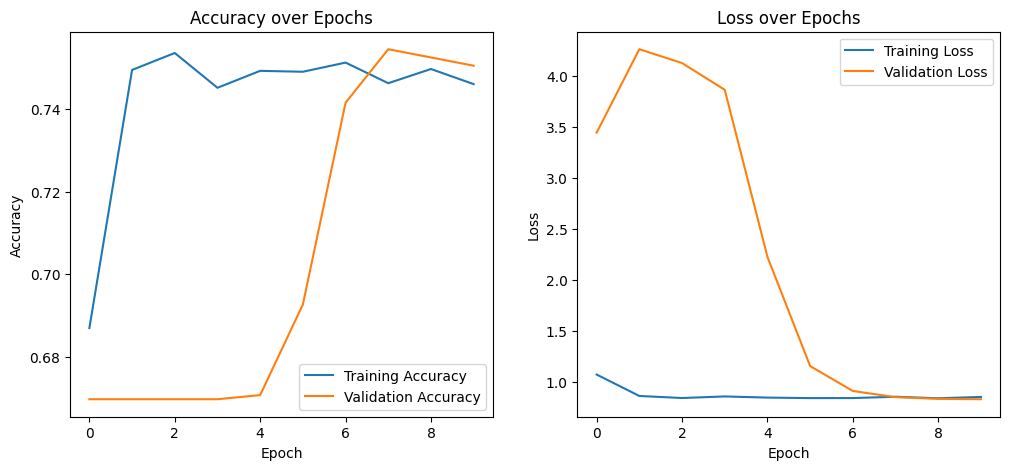

In [18]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Setting up the learning rate schedule
initial_learning_rate = 1e-3
final_learning_rate = 1e-5
decay_steps = 10
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps,
    decay_rate=(final_learning_rate / initial_learning_rate) ** (1 / decay_steps),
    staircase=True)

# Configuring the optimizer
optimizer = Adam(learning_rate=lr_schedule)

# Compiling the model
model_keras.compile(
    optimizer=optimizer,
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

# Setting up callbacks for saving the model and early stopping
checkpoint_cb = ModelCheckpoint(
    'akidanet_derma_best.h5', save_best_only=True)
early_stopping_cb = EarlyStopping(
    patience=5, restore_best_weights=True)

# Training the model
history = model_keras.fit(
    train_gen,
    epochs=10,
    validation_data=test_gen,
    callbacks=[checkpoint_cb, early_stopping_cb])

# Optionally, plot the training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# Function to convert generator to tf.data.Dataset
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

# Create a Dataset from the generator
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_gen,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
)

train_dataset = train_dataset.map(format_example, num_parallel_calls=tf.data.AUTOTUNE)

# Define batch size and batch the dataset
BATCH_SIZE = 32
train_batches = train_dataset.unbatch().batch(BATCH_SIZE)

## Quantize Model

In [20]:
from quantizeml.models import quantize, QuantizationParams, dump_config

# Prepare a quantization scheme: first layer weights to 8-bit, other weights and activation to 4-bit
qparams = QuantizationParams(input_weight_bits=8, weight_bits=4, activation_bits=4)

# Quantize the model, using the 1024 calibration samples from the train set and calibrate over 2
# epochs with a batch_size of 100.
model_quantized = quantize(model_keras, qparams=qparams,
                           samples=train_batches, epochs=2, batch_size=BATCH_SIZE, num_samples=1024)

/usr/local/lib/python3.8/dist-packages/quantizeml/models/quantize.py:98: UserWarning: 'act_softmax' of type <class 'keras.layers.core.activation.Activation'> is not supported to quantize, a Dequantizer is added before it and quantization will stop at this layer.
  warnings.warn(f"'{layer.name}' of type {layer.__class__} is not supported to "
2024-05-16 11:49:42.963208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


32/32 [==============================] - 3s 84ms/step


In [31]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: test_gen,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
)

test_dataset = test_dataset.map(format_example, num_parallel_calls=tf.data.AUTOTUNE)

# Define batch size and batch the dataset
BATCH_SIZE = 32
test_batches = test_dataset.unbatch().batch(BATCH_SIZE)

In [32]:
import numpy as np

def generator_to_numpy(generator):
    images_list = []
    labels_list = []

    # Iterate through the generator
    for _ in range(len(generator)):
        images, labels = generator.next()
        images_list.append(images)
        labels_list.append(labels)

    # Concatenate lists into numpy arrays
    x_test = np.concatenate(images_list, axis=0)
    labels_test = np.concatenate(labels_list, axis=0)

    return x_test, labels_test

# Example usage with test_gen
x_test, labels_test = generator_to_numpy(test_gen)

# Ensure the shapes are correct
print(x_test.shape)  # Should be (num_samples, 224, 224, 3)
print(labels_test.shape)  # Should be (num_samples,)


(1002, 224, 224, 3)
(1002,)


In [33]:
from timeit import default_timer as timer

model_quantized.compile(metrics=['accuracy'])


num_images = len(x_test)

start = timer()
potentials_keras = model_quantized.predict(x_test, batch_size=100)
end = timer()
print(f'Keras inference on {num_images} images took {end-start:.2f} s.\n')

preds_keras = np.squeeze(np.argmax(potentials_keras, 1))
accuracy_keras = np.sum(np.equal(preds_keras, labels_test)) / num_images
print(f"Keras accuracy: {accuracy_keras*num_images:.0f}/{num_images}.")

2024-05-16 11:58:59.792085: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: akidanet_derma/conv_0/aligned_weight_quantizer/assert_less/Assert/AssertGuard/branch_executed/_25


11/11 [==============================] - 4s 61ms/step
Keras inference on 1002 images took 4.44 s.

Keras accuracy: 671/1002.


In [34]:
model_quantized.save('model_quantized.h5')

In [35]:
import numpy as np
from cnn2snn import convert

model_akida = convert(model_quantized)


/usr/local/lib/python3.8/dist-packages/cnn2snn/quantizeml/blocks.py:160: UserWarning: Conversion stops at layer predictions because of a dequantizer. The end of the model is ignored:
___________________________________________________
Layer (type)
act_softmax (Activation)
reshape (Reshape)

  warnings.warn("Conversion stops" + stop_layer_msg + " because of a dequantizer. "


In [36]:
model_akida.summary()

                 Model Summary                  
________________________________________________
Input shape    Output shape  Sequences  Layers
[224, 224, 3]  [1, 1, 7]     1          27    
________________________________________________

_____________________________________________________________________
Layer (type)                       Output shape    Kernel shape    

================== SW/conv_0-dequantizer (Software) =================

conv_0 (InputConv2D)               [112, 112, 16]  (3, 3, 3, 16)   
_____________________________________________________________________
conv_1 (Conv2D)                    [112, 112, 32]  (3, 3, 16, 32)  
_____________________________________________________________________
conv_2 (Conv2D)                    [56, 56, 64]    (3, 3, 32, 64)  
_____________________________________________________________________
conv_3 (Conv2D)                    [56, 56, 64]    (3, 3, 64, 64)  
__________________________________________________________________

In [64]:
from tensorflow.keras.models import load_model
from akida_models import load_model


model_path = 'model_akida.fbz'
model = load_model(model_path)

model.summary()

                 Model Summary                  
________________________________________________
Input shape    Output shape  Sequences  Layers
[224, 224, 3]  [1, 1, 7]     1          27    
________________________________________________

_____________________________________________________________________
Layer (type)                       Output shape    Kernel shape    

================== SW/conv_0-dequantizer (Software) =================

conv_0 (InputConv2D)               [112, 112, 16]  (3, 3, 3, 16)   
_____________________________________________________________________
conv_1 (Conv2D)                    [112, 112, 32]  (3, 3, 16, 32)  
_____________________________________________________________________
conv_2 (Conv2D)                    [56, 56, 64]    (3, 3, 32, 64)  
_____________________________________________________________________
conv_3 (Conv2D)                    [56, 56, 64]    (3, 3, 64, 64)  
__________________________________________________________________

In [49]:
model_akida.save('model_akida.fbz')

In [38]:
# Check Model performance
start = timer()
accuracy_akida = model_akida.evaluate(x_test, labels_test)
end = timer()
print(f'Inference on {num_images} images took {end-start:.2f} s.\n')
print(f"Accuracy: {accuracy_akida*num_images:.0f}/{num_images}.")


Inference on 1002 images took 4.19 s.

Accuracy: 671/1002.


In [65]:
import numpy as np

# Assuming test_gen is already defined

# Get the class indices for each sample
class_indices = test_gen.classes

# Get the mapping from class names to indices
class_indices_mapping = test_gen.class_indices

# Create a reverse mapping from indices to class names
index_to_class = {v: k for k, v in class_indices_mapping.items()}

# Count the number of samples for each class
class_counts = np.bincount(class_indices)

# Print the number of samples for each class
print("Number of samples:", test_gen.samples)
print("Number of samples per class in the test generator:")
for class_index, count in enumerate(class_counts):
    class_name = index_to_class[class_index]
    print(f"{class_name}: {count}")


Number of samples: 1002
Number of samples per class in the test generator:
akiec: 33
bcc: 51
bkl: 110
df: 12
mel: 111
nv: 671
vasc: 14


Akida outputs: [-5.5879674 -2.6575031 -1.4395865 -1.3195293 -6.0729647  9.164673
 -1.536442 ]
True label: bkl
Predicted label: nv


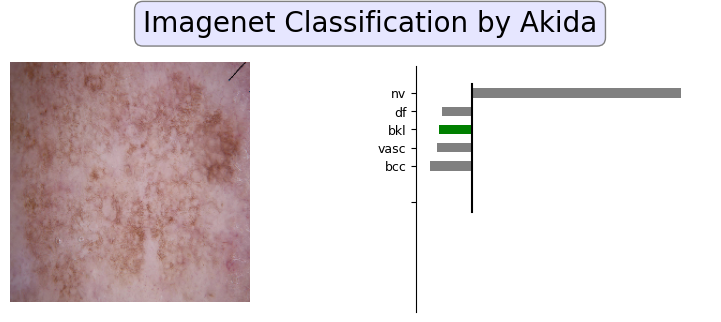

In [66]:
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from akida_models.imagenet import preprocessing

class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

IMAGE_SIZE = 224
NUM_CHANNELS = 3

# Functions used to display the top5 results
def get_top5(potentials, true_label):
    """
    Returns the top 5 classes from the output potentials
    """
    tmp_pots = potentials.copy()
    top5 = []
    min_val = np.min(tmp_pots)
    for ii in range(5):
        best = np.argmax(tmp_pots)
        top5.append(best)
        tmp_pots[best] = min_val

    vals = np.zeros((6,))
    vals[:5] = potentials[top5]

    if true_label not in top5:
        vals[5] = potentials[true_label]
    else:
        vals[5] = 0

    vals /= np.max(vals)

    class_name = []
    for ii in range(5):
        class_name.append(class_names[top5[ii]])
    if true_label in top5:
        class_name.append('')
    else:
        class_name.append(
            class_names[true_label])

    return top5, vals, class_name


def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
        else:
            spine.set_color('none')  # don't draw spine
    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])


def prepare_plots():
    fig = plt.figure(figsize=(8, 4))
    # Image subplot
    ax0 = plt.subplot(1, 3, 1)
    imgobj = ax0.imshow(np.zeros((IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS), dtype=np.uint8))
    ax0.set_axis_off()
    # Top 5 results subplot
    ax1 = plt.subplot(1, 2, 2)
    bar_positions = (0, 1, 2, 3, 4, 6)
    rects = ax1.barh(bar_positions, np.zeros((6,)), align='center', height=0.5)
    plt.xlim(-0.2, 1.01)
    ax1.set(xlim=(-0.2, 1.15), ylim=(-1.5, 12))
    ax1.set_yticks(bar_positions)
    ax1.invert_yaxis()
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks([])
    adjust_spines(ax1, 'left')
    ax1.add_line(lines.Line2D((0, 0), (-0.5, 6.5), color=(0.0, 0.0, 0.0)))
    # Adjust Plot Positions
    ax0.set_position([0.05, 0.055, 0.3, 0.9])
    l1, b1, w1, h1 = ax1.get_position().bounds
    ax1.set_position([l1 * 1.05, b1 + 0.09 * h1, w1, 0.8 * h1])
    # Add title box
    plt.figtext(0.5,
                0.9,
                "Imagenet Classification by Akida",
                size=20,
                ha="center",
                va="center",
                bbox=dict(boxstyle="round",
                          ec=(0.5, 0.5, 0.5),
                          fc=(0.9, 0.9, 1.0)))

    return fig, imgobj, ax1, rects


def update_bars_chart(rects, vals, true_label):
    counter = 0
    for rect, h in zip(rects, yvals):
        rect.set_width(h)
        if counter < 5:
            if top5[counter] == true_label:
                if counter == 0:
                    rect.set_facecolor((0.0, 1.0, 0.0))
                else:
                    rect.set_facecolor((0.0, 0.5, 0.0))
            else:
                rect.set_facecolor('gray')
        elif counter == 5:
            rect.set_facecolor('red')
        counter += 1


# Prepare plots
fig, imgobj, ax1, rects = prepare_plots()

# Get a random image
img = np.random.randint(num_images)

# Predict image class
outputs_akida = model_akida.predict(np.expand_dims(x_test[img].astype(np.uint8), axis=0)).squeeze()

# Get top 5 prediction labels and associated names
true_label = labels_test[img]
top5, yvals, class_name = get_top5(outputs_akida, true_label)

print("Akida outputs:", outputs_akida)
print("True label:", class_names[int(true_label)])
print("Predicted label:", class_names[np.argmax(outputs_akida)])

# Draw Plots
imgobj.set_data(x_test[img])
ax1.set_yticklabels(class_name, rotation='horizontal', size=9)
update_bars_chart(rects, yvals, true_label)
fig.canvas.draw()
plt.show()